# **360x Dataset EDA**

Quick exploratory checks on the 360x panoramic dataset: verify structure, inspect sample entries, and capture basic summary stats.

### Dataset context
- The [360+x project page](https://x360dataset.github.io/) describes the dataset as a **panoptic multi-modal scene understanding** corpus with 2,152 videos (8.579M frames) captured using 360° and Spectacles cameras across 17 cities in 5 countries, covering 28 scene categories spanning indoor and outdoor environments.
- Each video carries **temporal activity localization for 38 action classes**, synchronized **binaural audio** (with published delay statistics), and aligned third-person, panoramic, and binocular viewpoints to encourage cross-modal analysis.
- The downloadable packages on Hugging Face include both **high-resolution assets** (panoramic 5760×2880, binocular 2432×1216, front-view 1920×1080) and **lower-resolution variants** (panoramic/binocular 640×320, front-view 569×320), with shared JSON indices, class maps, and per-clip activity segmentation metadata.


## 1. Resolve dataset root

Uses the same resolution logic as the quickstart notebook: prefer `CAPTIONQA_DATASETS`, otherwise search upward for the repository root and fall back to `./datasets`.

In [86]:
from pathlib import Path
from itertools import islice
import json
import os
import numpy as np

def resolve_dataset_root() -> Path:
    env_root = os.environ.get('CAPTIONQA_DATASETS')
    if env_root:
        return Path(env_root).expanduser().resolve()
    cwd = Path.cwd()
    for candidate in [cwd, *cwd.parents]:
        if (candidate / 'pyproject.toml').exists() or (candidate / '.git').exists():
            return (candidate / 'datasets').resolve()
    return (cwd / 'datasets').resolve()

DATASET_ROOT = resolve_dataset_root()
print(f'Dataset root: {DATASET_ROOT}')
HR_ROOT = DATASET_ROOT / '360x' / '360x_dataset_HR'
LR_ROOT = DATASET_ROOT / '360x' / '360x_dataset_LR'
print(f'HR root: {HR_ROOT}')
print(f'LR root: {LR_ROOT}')

Dataset root: D:\CaptionQA\data
HR root: D:\CaptionQA\data\360x\360x_dataset_HR
LR root: D:\CaptionQA\data\360x\360x_dataset_LR


## 2. Validate presence & summarize

Run the next cell to verify the expected folder layout and capture a few file listings. The notebook handles missing data gracefully and prints next steps if the dataset is absent.

In [87]:
def describe_directory(root: Path, label: str, limit: int = 10):
    print(f'\n{label} -> {root}')
    if not root.exists():
        print(f'[missing] Not found. Download with: python -m captionqa.data.download 360x --output "{DATASET_ROOT}" --360x-resolution hr')
        return
    entries = sorted(root.iterdir())
    print(f'Total entries: {len(entries)}')
    for path in islice(entries, limit):
        print(' -', path.name)
    if len(entries) > limit:
        print(' ...')

describe_directory(HR_ROOT, 'High-resolution split')
describe_directory(LR_ROOT, 'Low-resolution split')


High-resolution split -> D:\CaptionQA\data\360x\360x_dataset_HR
[missing] Not found. Download with: python -m captionqa.data.download 360x --output "D:\CaptionQA\data" --360x-resolution hr

Low-resolution split -> D:\CaptionQA\data\360x\360x_dataset_LR
Total entries: 10
 - .cache
 - .gitattributes
 - binocular
 - ids.npy
 - index.json
 - monocular
 - panoramic
 - README.md
 - TAL_annotations
 - third_person


## 3. Sample metadata

If JSON metadata files are available, the next cell attempts to load one sample to inspect structure. Adjust the glob pattern if the dataset uses a different naming scheme.

In [88]:
def load_sample_metadata(root: Path, suffix: str = '.json'):
    if not root.exists():
        print('[skip] Root missing; nothing to load.')
        return
    for path in sorted(root.rglob(f'*{suffix}')):
        print(f'Previewing {path}')
        try:
            with path.open('r', encoding='utf-8') as handle:
                snippet = json.load(handle)
        except Exception as exc:
            print('Failed to parse JSON:', exc)
            return
        print(json.dumps(snippet, indent=2)[:2000])
        return
    print('[skip] No files matching suffix found.')

load_sample_metadata(HR_ROOT)
load_sample_metadata(LR_ROOT)

[skip] Root missing; nothing to load.
Previewing D:\CaptionQA\data\360x\360x_dataset_LR\index.json
[
  {
    "uuid": "0e7ca5c4-1340-48aa-b181-a6a28478bd3d",
    "binocular_files_number": 4,
    "capture_time": "20221201T175422",
    "category": "Indoor Residential Spaces",
    "weather": "indoor"
  },
  {
    "uuid": "089743db-6346-4606-a790-d29aa363ccd3",
    "binocular_files_number": 5,
    "capture_time": "20221129T220101",
    "category": "Indoor Residential Spaces",
    "weather": "indoor"
  },
  {
    "uuid": "3b0c3e20-577c-4bd1-be86-be5a3b94f4f2",
    "binocular_files_number": 4,
    "capture_time": "20221201T195910",
    "category": "Indoor Residential Spaces",
    "weather": "indoor"
  },
  {
    "uuid": "80b9c35c-2cce-40ac-bbce-bacb9e3f46ff",
    "binocular_files_number": 5,
    "capture_time": "20230107T072420",
    "category": "Indoor Entertainment Venues",
    "weather": "indoor"
  },
  {
    "uuid": "07526bd8-bbdf-411f-b958-68bbea1d2796",
    "binocular_files_number": 3,


## 4. Detailed roadmap 

### A. Data access & integrity audit
1. **Confirm environment authentication**
   - Verify `huggingface-cli whoami` succeeds so gated downloads remain accessible.
   - Mirror the final dataset root (HR vs LR) and capture the exact path in the notebook for reproducibility.
2. **Inventory archives & modality folders**
   - Programmatically list `panoramic/`, `binocular/`, `third_person/`, and `activity_segmentation/` directories; assert counts match published totals (2,152 full videos / 1,380 clips) once decompressed.
   - Parse `index.json` to extract per-item metadata (scene id, city, capture device, clip ids) and ensure all referenced files exist.
3. **Checksum / size validation (spot checks)**
   - Compute file sizes & optional hashes for a random stratified sample to confirm downloads are complete across modalities and resolutions.

### B. Metadata profiling
1. **Scene & geography coverage**
   - Load `index.json` into a DataFrame; summarize counts by `scene_category`, `city`, `country`, indoor/outdoor flag to verify the 28-scene, 17-city distribution.
   - Visualize distributions (bar charts, choropleth-ready tables) and highlight underrepresented categories.
2. **Action label analysis**
   - Iterate `activity_segmentation/*.json`; explode temporal segments to calculate frequency, duration, and co-occurrence of the 38 action classes.
   - Plot duration histograms and per-video action counts to reproduce/double-check dataset charts (e.g., number of actions per clip, time-of-day coverage).
3. **Clip segmentation review**
   - Confirm 1,380 ~10s clips by aggregating segment metadata, checking total duration (~244k seconds / 67.78 hours) against expectations.

### C. Video modality diagnostics
1. **Resolution & bitrate verification**
   - Use `ffprobe` (via `ffmpeg-python` or subprocess) on samples from each modality/resolution to confirm frame size, FPS, codec, audio channels.
   - Tabulate metrics to ensure panoramic videos retain 360° projection metadata (e.g., equirectangular tags).
2. **Temporal alignment checks**
   - For matching clip IDs across panoramic/front-view/binocular videos, compute start/end timestamps and verify synchronization with activity segments.
   - Overlay representative frames to inspect spatial correspondence between modalities.
3. **Quality spotlights**
   - Render thumbnails or short GIFs for a stratified sample (scene type × device) to visually inspect exposure, motion blur, and unique scenarios.

### D. Audio & binaural analysis
1. **Channel inspection**
   - Confirm audio streams are stereo/binaural; measure inter-channel delay statistics to compare with published histograms.
2. **Spectrogram profiling**
   - Generate Mel spectrograms for random clips to assess frequency coverage; store representative figures in the notebook.
3. **Cross-modal cues**
   - Correlate audio energy bursts with action segment timestamps to evaluate labeling quality.

### E. Feature & annotation validation
1. **Pre-computed feature parity**
   - If I3D/VGGish/ResNet-18 features are present, verify dimensionality and sample statistics; confirm number of feature files equals number of clips.
2. **Class mapping sanity checks**
   - Inspect `classes.json` to validate naming consistency between metadata and activity labels; flag missing or duplicate entries.

### F. Documentation & reproducibility
1. **Record assumptions & gaps**
   - Maintain a running log within the notebook capturing any anomalies (missing files, corrupted clips) and remediation steps.
2. **Outline next analytical directions**
   - Based on findings, prioritize deeper tasks (e.g., pose estimation feasibility, QA pair synthesis), linking them to concrete dataset evidence.


In [89]:
# A.1 Confirm environment authentication and capture dataset root
from huggingface_hub import HfApi
import os

try:
    info = HfApi().whoami()
    user = info.get('name') or info.get('email') or '<unknown>'
    print('Hugging Face auth: OK -', user)
except Exception as exc:
    print('Hugging Face auth: NOT AUTHENTICATED')
    print('Hint: run "huggingface-cli login" or set HF_TOKEN before downloads.')

print('CAPTIONQA_DATASETS =', os.environ.get('CAPTIONQA_DATASETS', '<unset>'))
print('Using dataset root =', DATASET_ROOT)
print('HR root =', HR_ROOT)
print('LR root =', LR_ROOT)

Hugging Face auth: OK - Quiixotic
CAPTIONQA_DATASETS = <unset>
Using dataset root = D:\CaptionQA\data
HR root = D:\CaptionQA\data\360x\360x_dataset_HR
LR root = D:\CaptionQA\data\360x\360x_dataset_LR


### A.2 Inventory modality folders

In [90]:
from collections import defaultdict

def inventory_videos(root: Path):
    report = {}
    if not root.exists():
        return report
    candidates = ['binocular', 'panoramic', 'front_view', 'third_person', 'activity_segmentation', 'TAL_annotations']
    for name in candidates:
        path = root / name
        if path.exists():
            if name.lower() in ('tal_annotations', 'activity_segmentation'):
                count = len(list(path.glob('*.json')))
                report[name] = {'type': 'annotations', 'count': count, 'path': str(path)}
            else:
                vids = list(path.rglob('*.mp4'))
                report[name] = {'type': 'video', 'count': len(vids), 'path': str(path)}
    if not report:
        vids = list(root.rglob('*.mp4'))
        report['all_videos'] = {'type': 'video', 'count': len(vids), 'path': str(root)}
    return report

print('HR inventory:')
hr_inv = inventory_videos(HR_ROOT)
for k, v in hr_inv.items():
    print(f" - {k:<18} {v['type']:<10} {v['count']:>6} @ {v['path']}")

print('LR inventory:')
lr_inv = inventory_videos(LR_ROOT)
for k, v in lr_inv.items():
    print(f" - {k:<18} {v['type']:<10} {v['count']:>6} @ {v['path']}")

HR inventory:
LR inventory:
 - binocular          video         844 @ D:\CaptionQA\data\360x\360x_dataset_LR\binocular
 - panoramic          video         231 @ D:\CaptionQA\data\360x\360x_dataset_LR\panoramic
 - third_person       video         232 @ D:\CaptionQA\data\360x\360x_dataset_LR\third_person
 - TAL_annotations    annotations    232 @ D:\CaptionQA\data\360x\360x_dataset_LR\TAL_annotations


### A.3 Parse index/classes (if present)

In [91]:
candidates = list(LR_ROOT.rglob('index.json')) + list(LR_ROOT.rglob('classes.json'))
if not candidates:
    print('[info] No index.json or classes.json found under LR root.')
else:
    for p in candidates[:5]:
        try:
            with p.open('r', encoding='utf-8') as h:
                obj = json.load(h)
        except Exception as exc:
            print('Failed to parse', p, '->', exc)
            continue
        keys = list(obj) if isinstance(obj, dict) else (list(obj[0].keys()) if isinstance(obj, list) and obj else [])
        print(f'Parsed {p} | keys: {keys[:10]}')

Parsed D:\CaptionQA\data\360x\360x_dataset_LR\index.json | keys: ['uuid', 'binocular_files_number', 'capture_time', 'category', 'weather']


### A.4 Spot-check file sizes and hashes

In [92]:
import random, hashlib

def sample_files(report: dict, n: int = 3):
    samples = {}
    for name, entry in report.items():
        if entry.get('type') == 'video':
            files = sorted(Path(entry['path']).rglob('*.mp4'))
            if files:
                k = min(n, len(files))
                samples[name] = random.sample(files, k)
    return samples

def sha256_limited(path: Path, max_bytes: int = 5 * 1024 * 1024):
    h = hashlib.sha256()
    total = 0
    with path.open('rb') as f:
        while total < max_bytes:
            chunk = f.read(min(1024 * 1024, max_bytes - total))
            if not chunk:
                break
            h.update(chunk)
            total += len(chunk)
    return h.hexdigest(), total

samples = sample_files(lr_inv, n=3)
for name, files in samples.items():
    print(f'{name} samples ({len(files)}):')
    for p in files:
        try:
            size = p.stat().st_size
        except Exception as exc:
            print(' -', p, '-> stat failed:', exc)
            continue
        digest, scanned = sha256_limited(p)
        print(f' - {p.name:40s} size={size:,}B sha256[:8]={digest[:8]} scanned={scanned:,}B')

binocular samples (3):
 - clip1.mp4                                size=1,677,899B sha256[:8]=9fa0936b scanned=1,677,899B
 - clip1.mp4                                size=1,756,397B sha256[:8]=c256691d scanned=1,756,397B
 - clip2.mp4                                size=2,350,615B sha256[:8]=3b64e95f scanned=2,350,615B
panoramic samples (3):
 - 1bea9255-ab5f-454c-8845-6b9505c0f5d7.mp4 size=18,156,919B sha256[:8]=40eaeb1c scanned=5,242,880B
 - afb92f9c-2b67-439e-a638-6442cf6e724e.mp4 size=19,086,582B sha256[:8]=115b7dfe scanned=5,242,880B
 - 4b2e32c6-10c0-41ae-bc5d-7449032568b8.mp4 size=14,688,866B sha256[:8]=ae3b941d scanned=5,242,880B
third_person samples (3):
 - 9d8ab455-ebb1-4e6b-92b4-e9d0afd49e31.mp4 size=32,782,588B sha256[:8]=3ca9e5f5 scanned=5,242,880B
 - 73c6c7f4-7ef1-4dd1-915f-2cbb6423aec5.mp4 size=25,027,209B sha256[:8]=ac12671c scanned=5,242,880B
 - f5492abc-8bd4-4539-9a90-ba01412b4c38.mp4 size=37,116,480B sha256[:8]=971f3637 scanned=5,242,880B


## B. Metadata profiling

In [93]:
# B.1 Load index.json (if present) and basic summaries
try:
    import pandas as pd  # optional
    HAVE_PD = True
except Exception:
    HAVE_PD = False

def find_index_file(root: Path):
    for name in ['index.json']:
        for p in root.rglob(name):
            return p
    return None

index_path = find_index_file(LR_ROOT)
if not index_path:
    print('[info] index.json not found under LR root; skipping index-based profiling.')
else:
    print('index.json:', index_path)
    try:
        with index_path.open('r', encoding='utf-8') as h:
            index_obj = json.load(h)
    except Exception as exc:
        print('Failed to parse index.json:', exc)
        index_obj = None

    if index_obj is not None and HAVE_PD and isinstance(index_obj, list) and index_obj:
        df = pd.DataFrame(index_obj)
        print('index rows:', len(df), '| columns:', list(df.columns)[:15])
        known_cols = ['category','weather','scene_category','city','country','indoor_outdoor','capture_time']
        selected = [c for c in known_cols if c in df.columns]
        if not selected:
            # fallback: summarize a few object/categorical columns
            selected = [c for c in df.columns if str(df[c].dtype) == 'object'][:4]
        for col in selected:
            vc = df[col].value_counts().head(10)
            print(f'\nTop {col}:')
            print(vc)
    else:
        if not HAVE_PD:
            print('[note] pandas not available; install pandas to see tables.')
        else:
            print('[info] index.json not a list of objects or empty; skipping table summaries.')

index.json: D:\CaptionQA\data\360x\360x_dataset_LR\index.json
index rows: 232 | columns: ['uuid', 'binocular_files_number', 'capture_time', 'category', 'weather']

Top category:
category
Urban Constructions & street         33
Dining & Food Outlets                23
Artistic Spaces                      21
Indoor Residential Spaces            18
Transportation Interiors             15
Kitchen                              14
Outdoor Commercial & Markets         14
Historic & Religious Sites           12
Indoor Shops & Retail& Commercial     9
Agriculture & Rural                   8
Name: count, dtype: int64

Top weather:
weather
indoor        115
sunny          38
clear          32
cloudy         21
haze           13
rainy          12
haze+rainy      1
Name: count, dtype: int64

Top capture_time:
capture_time
20220101T000000    21
20221113T164253     2
20231017T084914     2
20231021T141801     2
20221201T175422     1
20221204T183330     1
20230120T092753     1
20230107T072420     1
20221

In [94]:
# B.2 Aggregate action labels and durations from annotations
from collections import Counter, defaultdict
from typing import DefaultDict

def get_annotations_dir(root: Path) -> Path | None:
    for name in ['activity_segmentation', 'TAL_annotations']:
        p = root / name
        if p.exists():
            return p
    return None

ann_dir = get_annotations_dir(LR_ROOT)
if not ann_dir:
    print('[info] No annotations directory found under LR root.')
    ann_files = []
else:
    ann_files = sorted(ann_dir.glob('*.json'))
    print(f'Annotations dir: {ann_dir} | files: {len(ann_files)}')

label_counts: Counter[str] = Counter()
label_durations: DefaultDict[str, float] = defaultdict(float)
total_segments = 0

def extract_segments(aobj) -> list[dict]:
    segs = []
    if isinstance(aobj, dict):
        # Try common top-level keys first
        for key in ['segments','actions','annotations','activity_segments','activity_segmentation']:
            if key in aobj and isinstance(aobj[key], list):
                segs = aobj[key]
                break
        # Handle 360x TAL-style: 'metadata' is a dict of entries with 'duration' [s,e] and 'action' dict
        if not segs and 'metadata' in aobj and isinstance(aobj['metadata'], dict):
            for mid, rec in aobj['metadata'].items():
                if not isinstance(rec, dict):
                    continue
                dur = rec.get('duration')
                act = rec.get('action')
                # Extract label from action which may be dict like {'1': 'walking'} or list/str
                label = None
                if isinstance(act, dict) and act:
                    try:
                        label = next(iter(act.values()))
                    except Exception:
                        label = None
                elif isinstance(act, list) and act:
                    label = act[0]
                elif isinstance(act, str):
                    label = act
                # Duration expected as [start, end]
                if isinstance(dur, (list, tuple)) and len(dur) == 2:
                    try:
                        s, e = float(dur[0]), float(dur[1])
                        segs.append({'label': label, 'start': s, 'end': e})
                    except Exception:
                        pass
            if segs:
                return segs
        # Fallback: first list of dicts among values
        if not segs:
            for v in aobj.values():
                if isinstance(v, list) and v and isinstance(v[0], dict):
                    segs = v
                    break
        # Handle ActivityNet/THUMOS-like mapping: label -> [[s,e], ...]
        if not segs:
            for k, v in aobj.items():
                if isinstance(v, list) and v and isinstance(v[0], (list, tuple)) and len(v[0]) == 2:
                    # Treat key as label and values as segments
                    for pair in v:
                        try:
                            s, e = float(pair[0]), float(pair[1])
                        except Exception:
                            continue
                        segs.append({'label': k, 'start': s, 'end': e})
            if segs:
                return segs
        # Handle nested 'database' structures (ActivityNet-like)
        if 'database' in aobj and isinstance(aobj['database'], dict):
            for vid, rec in aobj['database'].items():
                if isinstance(rec, dict) and isinstance(rec.get('annotations'), list):
                    for ann in rec['annotations']:
                        label = ann.get('label') or ann.get('class') or ann.get('name')
                        seg = ann.get('segment') or ann.get('timestamps')
                        if isinstance(seg, (list, tuple)) and len(seg) == 2:
                            try:
                                s, e = float(seg[0]), float(seg[1])
                                segs.append({'label': label, 'start': s, 'end': e})
                            except Exception:
                                pass
            if segs:
                return segs
    elif isinstance(aobj, list) and aobj and isinstance(aobj[0], dict):
        segs = aobj
    norm = []
    for s in segs:
        if not isinstance(s, dict):
            continue
        label = s.get('label') or s.get('class') or s.get('action') or s.get('name') or s.get('category') or s.get('class_name')
        # Support explicit start/end fields
        start = s.get('start') or s.get('start_time') or s.get('ts_start') or s.get('start_sec') or s.get('start_seconds')
        end = s.get('end') or s.get('end_time') or s.get('ts_end') or s.get('end_sec') or s.get('end_seconds')
        # Support 'segment' / 'timestamps' fields as [start, end] or a list of such pairs
        seg_field = s.get('segment') or s.get('segments') or s.get('timestamps')
        if seg_field is not None:
            # If it's a single pair
            if isinstance(seg_field, (list, tuple)) and len(seg_field) == 2 and not isinstance(seg_field[0], (list, tuple)):
                try:
                    start = float(seg_field[0]); end = float(seg_field[1])
                except Exception:
                    pass
            # If it's a list of pairs, expand into multiple segments
            elif isinstance(seg_field, list) and seg_field and isinstance(seg_field[0], (list, tuple)) and len(seg_field[0]) == 2:
                for pair in seg_field:
                    try:
                        ss, ee = float(pair[0]), float(pair[1])
                    except Exception:
                        continue
                    norm.append({'label': label, 'start': ss, 'end': ee})
                # We already expanded, skip the default append below
                label = None
        duration = s.get('duration') or s.get('dur')
        # Derive end from start+duration if needed
        if (start is not None) and (end is None) and (duration is not None):
            try:
                end = float(start) + float(duration)
            except Exception:
                pass
        # Handle single timestamp + duration
        if start is None:
            t = s.get('time') or s.get('timestamp')
            if t is not None:
                start = t
                if end is None and duration is not None:
                    try:
                        end = float(t) + float(duration)
                    except Exception:
                        pass
        if label is not None:
            norm.append({'label': label, 'start': start, 'end': end})
    return norm

for ap in ann_files[:2000]:  # cap for speed if huge
    try:
        with ap.open('r', encoding='utf-8') as h:
            aobj = json.load(h)
    except Exception as exc:
        print(' - failed to parse', ap.name, '->', exc)
        continue
    segments = extract_segments(aobj)
    for s in segments:
        label = s.get('label')
        start = s.get('start')
        end = s.get('end')
        try:
            dur = float(end) - float(start) if end is not None and start is not None else 0.0
        except Exception:
            dur = 0.0
        if label:
            label_counts[label] += 1
            label_durations[label] += max(dur, 0.0)
            total_segments += 1

print('Total segments parsed:', total_segments)
if total_segments == 0 and ann_files:
    # Brief schema diagnostic to aid adaptation without dumping entire file
    p0 = ann_files[0]
    try:
        with p0.open('r', encoding='utf-8') as h:
            obj0 = json.load(h)
        if isinstance(obj0, dict):
            print('[diag] First annotation keys:', list(obj0.keys())[:20])
            if 'annotations' in obj0 and isinstance(obj0['annotations'], list) and obj0['annotations']:
                first_ann = obj0['annotations'][0]
                if isinstance(first_ann, dict):
                    print('[diag] annotations[0] keys:', list(first_ann.keys())[:20])
        elif isinstance(obj0, list) and obj0 and isinstance(obj0[0], dict):
            print('[diag] First list item keys:', list(obj0[0].keys())[:20])
    except Exception as exc:
        print('[diag] Failed to inspect first annotation:', exc)
top_counts = sorted(label_counts.items(), key=lambda x: x[1], reverse=True)[:15]
top_dur = sorted(label_durations.items(), key=lambda x: x[1], reverse=True)[:15]
print('\nTop labels by count:')
for k,v in top_counts:
    print(f' - {k}: {v}')
print('\nTop labels by total duration (s):')
for k,v in top_dur:
    print(f' - {k}: {v:.1f}')

Annotations dir: D:\CaptionQA\data\360x\360x_dataset_LR\TAL_annotations | files: 232
Total segments parsed: 4470

Top labels by count:
 - speaking: 942
 - walking: 824
 - operating phone: 543
 - dressing: 327
 - drinking: 223
 - firework: 177
 - eating: 165
 - laughing: 124
 - moving things: 121
 - coughing: 83
 - playing instrument: 75
 - workout: 73
 - opening: 65
 - sitting: 63
 - standing: 60

Top labels by total duration (s):
 - walking: 12834.5
 - speaking: 11071.8
 - operating phone: 10747.3
 - eating: 5448.4
 - playing instrument: 2731.5
 - firework: 2429.8
 - playing: 1587.4
 - preparing food: 1402.5
 - reading: 1190.3
 - operating computer: 1135.8
 - photographing: 1135.4
 - drinking: 1070.8
 - dressing: 1048.1
 - housekeeping: 998.0
 - workout: 957.8


## C. Video modality diagnostics

In [95]:
# C.1 ffprobe sample across modalities
import shutil, subprocess

def has_ffprobe() -> bool:
    return shutil.which('ffprobe') is not None

def ffprobe_info(path: Path) -> dict | None:
    try:
        res = subprocess.run([
            'ffprobe','-v','error','-print_format','json','-show_streams','-show_format',str(path)
        ], capture_output=True, text=True, check=True)
        return json.loads(res.stdout)
    except Exception as exc:
        print('ffprobe failed for', path, '->', exc)
        return None

if not has_ffprobe():
    print('[info] ffprobe not found on PATH; install FFmpeg to enable diagnostics.')
else:
    # Collect a few samples per video modality from HR inventory computed earlier
    samples = {}
    inv = lr_inv if 'lr_inv' in globals() else {}
    for name, entry in inv.items():
        if entry.get('type') == 'video':
            files = sorted(Path(entry['path']).rglob('*.mp4'))[:2]
            if files:
                samples[name] = files
    if not samples:
        print('[info] No LR video files found to probe.')
    for mod, files in samples.items():
        print(f'\nModality: {mod}')
        for p in files:
            info = ffprobe_info(p)
            if not info:
                continue
            v = next((s for s in info.get('streams', []) if s.get('codec_type')=='video'), None)
            a = next((s for s in info.get('streams', []) if s.get('codec_type')=='audio'), None)
            if v:
                wh = (v.get('width'), v.get('height'))
                fps = v.get('avg_frame_rate')
                vcodec = v.get('codec_name')
            else:
                wh = (None,None); fps=None; vcodec=None
            if a:
                ach = a.get('channels'); asr = a.get('sample_rate'); acodec = a.get('codec_name')
            else:
                ach=None; asr=None; acodec=None
            print(f' - {p.name}: video={wh} fps={fps} vcodec={vcodec} | audio ch={ach} sr={asr} acodec={acodec}')


Modality: binocular
 - clip1.mp4: video=(640, 320) fps=2997/100 vcodec=h264 | audio ch=2 sr=44100 acodec=aac
 - clip2.mp4: video=(640, 320) fps=2997/100 vcodec=h264 | audio ch=2 sr=44100 acodec=aac

Modality: panoramic
 - 019cc67f-512f-4b8a-96ef-81f806c86ce1.mp4: video=(640, 320) fps=25/1 vcodec=h264 | audio ch=2 sr=48000 acodec=aac
 - 02594cd1-c13c-4fbe-a804-f8d8c72ca409.mp4: video=(640, 320) fps=25/1 vcodec=h264 | audio ch=2 sr=48000 acodec=aac

Modality: third_person
 - 019cc67f-512f-4b8a-96ef-81f806c86ce1.mp4: video=(570, 320) fps=25/1 vcodec=h264 | audio ch=2 sr=48000 acodec=aac
 - 02594cd1-c13c-4fbe-a804-f8d8c72ca409.mp4: video=(570, 320) fps=25/1 vcodec=h264 | audio ch=2 sr=48000 acodec=aac


In [96]:
# C.2 Lightweight temporal alignment checks between annotations and videos
def find_related_videos(root: Path, key: str, exts=('.mp4',)):
    found = []
    if not root.exists():
        return found
    for ext in exts:
        for p in root.rglob(f'*{ext}'):
            s = str(p)
            if key in s:
                found.append(p)
    return found[:5]

if ann_files:
    sample_keys = [p.stem for p in ann_files[:3]]
    for key in sample_keys:
        print(f'\nAnnotation key: {key}')
        for mod in ['panoramic','front_view','third_person','binocular']:
            mod_path = LR_ROOT / mod
            vids = find_related_videos(mod_path, key)
            print(f' - {mod}: {len(vids)} matches')
            for v in vids:
                print('   ->', v.name)
else:
    print('[info] No annotations found to drive alignment checks.')


Annotation key: 019cc67f-512f-4b8a-96ef-81f806c86ce1
 - panoramic: 1 matches
   -> 019cc67f-512f-4b8a-96ef-81f806c86ce1.mp4
 - front_view: 0 matches
 - third_person: 1 matches
   -> 019cc67f-512f-4b8a-96ef-81f806c86ce1.mp4
 - binocular: 5 matches
   -> clip1.mp4
   -> clip2.mp4
   -> clip3.mp4
   -> clip4.mp4
   -> clip5.mp4

Annotation key: 02594cd1-c13c-4fbe-a804-f8d8c72ca409
 - panoramic: 1 matches
   -> 02594cd1-c13c-4fbe-a804-f8d8c72ca409.mp4
 - front_view: 0 matches
 - third_person: 1 matches
   -> 02594cd1-c13c-4fbe-a804-f8d8c72ca409.mp4
 - binocular: 2 matches
   -> clip1.mp4
   -> clip2.mp4

Annotation key: 02692940-fd94-4af1-8ebc-577acacc617a
 - panoramic: 1 matches
   -> 02692940-fd94-4af1-8ebc-577acacc617a.mp4
 - front_view: 0 matches
 - third_person: 1 matches
   -> 02692940-fd94-4af1-8ebc-577acacc617a.mp4
 - binocular: 1 matches
   -> clip1.mp4


## D. Audio & binaural analysis

In [97]:
# D.1 Confirm stereo/binaural via ffprobe (reuses C.1 helpers)
if has_ffprobe():
    checked = 0
    for name, entry in (lr_inv if 'lr_inv' in globals() else {}).items():
        if entry.get('type') == 'video' and checked < 3:
            files = sorted(Path(entry['path']).rglob('*.mp4'))[:1]
            for p in files:
                info = ffprobe_info(p)
                a = next((s for s in info.get('streams', []) if s.get('codec_type')=='audio'), None) if info else None
                if a:
                    print(f"{p.name}: channels={a.get('channels')} layout={a.get('channel_layout')} sample_rate={a.get('sample_rate')}")
            checked += 1
else:
    print('[info] ffprobe not available; skipping audio channel checks.')

clip1.mp4: channels=2 layout=stereo sample_rate=44100
019cc67f-512f-4b8a-96ef-81f806c86ce1.mp4: channels=2 layout=stereo sample_rate=48000
019cc67f-512f-4b8a-96ef-81f806c86ce1.mp4: channels=2 layout=stereo sample_rate=48000


C:\Users\willj\AppData\Local\Temp\ipykernel_52940\1084384951.py:20: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(str(p), sr=22050, mono=False, duration=5.0)
c:\Users\willj\Documents\Coding Projects\CaptionQA\captionqa\lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


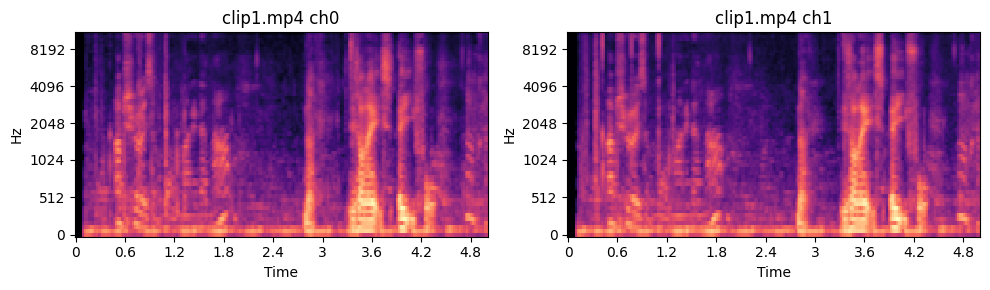

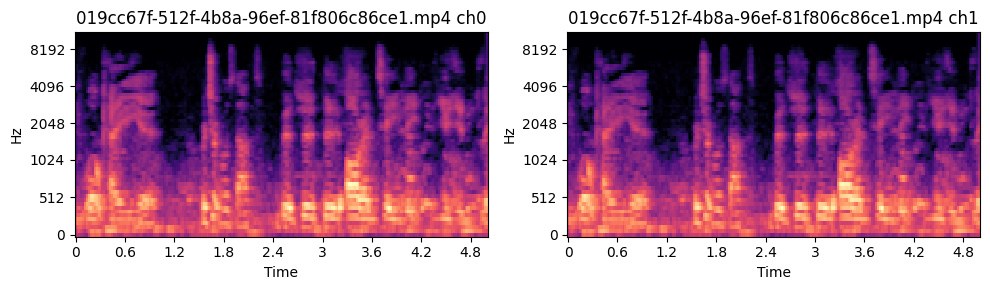

In [98]:
# D.2 Optional: Mel spectrograms for 1–2 samples (requires librosa & matplotlib)
try:
    import librosa, librosa.display  # type: ignore
    import matplotlib.pyplot as plt  # type: ignore
    HAVE_AUDIO_PLOTS = True
except Exception:
    HAVE_AUDIO_PLOTS = False

if not HAVE_AUDIO_PLOTS:
    print('[note] librosa/matplotlib not available; skipping spectrograms.')
else:
    # Pick 1–2 mp4 with audio
    picked = []
    for name, entry in (lr_inv if 'lr_inv' in globals() else {}).items():
        if entry.get('type') == 'video' and len(picked) < 2:
            files = sorted(Path(entry['path']).rglob('*.mp4'))[:1]
            picked.extend(files)
    for p in picked:
        try:
            y, sr = librosa.load(str(p), sr=22050, mono=False, duration=5.0)
            if y.ndim == 1:
                y = y[None, :]  # make (1, T) for consistency
            fig, ax = plt.subplots(1, y.shape[0], figsize=(10, 3))
            if y.shape[0] == 1:
                ax = [ax]
            for ch in range(y.shape[0]):
                S = librosa.feature.melspectrogram(y=y[ch], sr=sr, n_mels=64)
                S_dB = librosa.power_to_db(S, ref=np.max) if 'np' in globals() else S
                librosa.display.specshow(S_dB, sr=sr, ax=ax[ch], y_axis='mel', x_axis='time')
                ax[ch].set_title(f'{p.name} ch{ch}')
            plt.tight_layout(); plt.show()
        except Exception as exc:
            print('spectrogram failed for', p.name, '->', exc)

## E. Feature & annotation validation

In [99]:
# E.1 Class mapping sanity checks
classes_path = next(iter(LR_ROOT.rglob('classes.json')), None)
if not classes_path:
    print('[info] classes.json not found under LR root.')
    # Fallback: derive classes from annotations loaded in B.2
    if 'label_counts' in globals() and label_counts:
        derived = sorted(label_counts.keys())
        print(f'[info] Derived {len(derived)} classes from annotations.')
        print('First 10:', derived[:10])
        CREATE_CLASSES_FROM_ANN = globals().get('CREATE_CLASSES_FROM_ANN', False)
        if CREATE_CLASSES_FROM_ANN:
            outp = LR_ROOT / 'classes_from_annotations.json'
            try:
                with outp.open('w', encoding='utf-8') as h:
                    json.dump(derived, h, indent=2)
                print('Wrote derived classes to:', outp)
            except Exception as exc:
                print('Failed to write derived classes:', exc)
    else:
        print('[hint] Run the annotations cell (B.2) first to derive labels.')
else:
    try:
        with classes_path.open('r', encoding='utf-8') as h:
            classes_obj = json.load(h)
        if isinstance(classes_obj, dict):
            class_set = set(classes_obj.keys()) | set(classes_obj.values())
        elif isinstance(classes_obj, list):
            class_set = set(classes_obj)
        else:
            class_set = set()
    except Exception as exc:
        print('Failed to parse classes.json:', exc)
        class_set = set()
    # Compare against labels parsed in B.2
    if class_set and label_counts:
        labels_in_ann = set(label_counts.keys())
        missing_in_classes = sorted(labels_in_ann - class_set)[:20]
        print('Labels present in annotations but not in classes.json (first 20):', missing_in_classes)
    else:
        print('[info] Skipping comparison (no classes or no labels loaded).')

[info] classes.json not found under LR root.
[info] Derived 38 classes from annotations.
First 10: ['Assisting', 'alarming', 'clapping', 'cleaning', 'cooking', 'coughing', 'dancing', 'dressing', 'drinking', 'driving']


In [100]:
# E.2 Feature parity check (if features are downloaded)
try:
    import numpy as np  # optional
    HAVE_NP = True
except Exception:
    HAVE_NP = False

feature_dirs = [p for p in LR_ROOT.rglob('*') if p.is_dir() and any(k in p.name.lower() for k in ['feature','i3d','vggish','resnet'])]
if not feature_dirs:
    print('[info] No feature directories detected under LR root.')
    print('[hint] Optionally enable GENERATE_SAMPLE_FEATURES in the next cell to compute tiny sample features for a few videos.')
else:
    print('Feature directories detected:', [d.name for d in feature_dirs[:5]])
    feat_files = []
    for d in feature_dirs:
        feat_files.extend(list(d.rglob('*.npy')))
    print('Total .npy feature files:', len(feat_files))
    if HAVE_NP and feat_files[:3]:
        for fp in feat_files[:3]:
            try:
                arr = np.load(fp)
                print(fp.name, '-> shape', getattr(arr, 'shape', None), 'dtype', getattr(arr, 'dtype', None))
            except Exception as exc:
                print('failed to load', fp.name, '->', exc)
    elif not HAVE_NP:
        print('[note] numpy not available; skipping feature shape checks.')

[info] No feature directories detected under LR root.
[hint] Optionally enable GENERATE_SAMPLE_FEATURES in the next cell to compute tiny sample features for a few videos.


In [101]:
# E.2.a Optional: generate tiny sample features (image embeddings) for a few LR videos
# Set this to True to enable. Requires torch and torchvision.
GENERATE_SAMPLE_FEATURES = True

if GENERATE_SAMPLE_FEATURES:
    try:
        import torch, torchvision
        from torchvision import transforms
        import cv2  # type: ignore
        import numpy as np
        out_dir = LR_ROOT / 'features' / 'resnet18_sample'
        out_dir.mkdir(parents=True, exist_ok=True)
        model = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.DEFAULT)
        model.eval(); model.fc = torch.nn.Identity()
        preproc = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((224,224)),
            transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
        ])
        # Pick up to 2 videos per modality
        picks = []
        for name, entry in (lr_inv if 'lr_inv' in globals() else {}).items():
            if entry.get('type') == 'video' and len(picks) < 6:
                files = sorted(Path(entry['path']).rglob('*.mp4'))[:2]
                picks.extend(files)
        for vp in picks:
            try:
                cap = cv2.VideoCapture(str(vp))
                total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) or 1
                cap.set(cv2.CAP_PROP_POS_FRAMES, max(0, total//2))
                ok, frame = cap.read(); cap.release()
                if not ok:
                    print('failed to read frame from', vp.name); continue
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                x = preproc(frame).unsqueeze(0)
                with torch.no_grad():
                    feat = model(x).squeeze(0).cpu().numpy()
                np.save(out_dir / (vp.stem + '.npy'), feat)
                print('wrote feature', out_dir / (vp.stem + '.npy'))
            except Exception as exc:
                print('feature gen failed for', vp.name, '->', exc)
    except Exception as exc:
        print('[note] Skipping sample features (missing deps?):', exc)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\willj/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:18<00:00, 2.51MB/s]



wrote feature D:\CaptionQA\data\360x\360x_dataset_LR\features\resnet18_sample\clip1.npy
wrote feature D:\CaptionQA\data\360x\360x_dataset_LR\features\resnet18_sample\clip2.npy
wrote feature D:\CaptionQA\data\360x\360x_dataset_LR\features\resnet18_sample\019cc67f-512f-4b8a-96ef-81f806c86ce1.npy
wrote feature D:\CaptionQA\data\360x\360x_dataset_LR\features\resnet18_sample\02594cd1-c13c-4fbe-a804-f8d8c72ca409.npy
wrote feature D:\CaptionQA\data\360x\360x_dataset_LR\features\resnet18_sample\019cc67f-512f-4b8a-96ef-81f806c86ce1.npy
wrote feature D:\CaptionQA\data\360x\360x_dataset_LR\features\resnet18_sample\02594cd1-c13c-4fbe-a804-f8d8c72ca409.npy


## F. Findings and reproducibility

In [102]:
# F.1 Summary snapshot of environment & checks
def availability(pkg_name: str) -> bool:
    try:
        __import__(pkg_name)
        return True
    except Exception:
        return False

print('Dataset root:', DATASET_ROOT)
print('HR exists:', HR_ROOT.exists(), '| LR exists:', LR_ROOT.exists())
print('Annotations count (LR):', len(ann_files) if 'ann_files' in globals() else 0)
print('Modalities (LR):', list((k for k,v in (lr_inv if 'lr_inv' in globals() else {}).items() if v.get('type')=='video')))
print('ffprobe available:', has_ffprobe() if 'has_ffprobe' in globals() else False)
print('pandas:', availability('pandas'), '| numpy:', availability('numpy'), '| librosa:', availability('librosa'))

print('\nRe-run guidance:')
print('- Set CAPTIONQA_DATASETS or place datasets under repo_root/datasets')
print('- Ensure FFmpeg (ffprobe) is installed and on PATH')
print('- Install optional deps for richer EDA: pandas, numpy, matplotlib, librosa')

Dataset root: D:\CaptionQA\data
HR exists: False | LR exists: True
Annotations count (LR): 232
Modalities (LR): ['binocular', 'panoramic', 'third_person']
ffprobe available: True
pandas: True | numpy: True | librosa: True

Re-run guidance:
- Set CAPTIONQA_DATASETS or place datasets under repo_root/datasets
- Ensure FFmpeg (ffprobe) is installed and on PATH
- Install optional deps for richer EDA: pandas, numpy, matplotlib, librosa


### Notes
- Record any anomalies here (missing files, parse errors, mismatched classes).
- Add TODOs for deeper analyses (pose feasibility, QA synthesis candidates, cross-modal alignment visuals).